# Prédiction de la consommation d'électricité en France :

Projet developpement logiciel 

Traîtement des données sur Jupyter Notebook (distribution Anaconda) 

Etude réalisée en language Python 

Source des données : [Données annuelles de la consommation brute d'électricité du 1er Janvier 2012 au 31 mai 2022](https://www.data.gouv.fr/fr/datasets/pic-journalier-de-la-consommation-brute-delectricite-janvier-2012-a-septembre-2022/)


In [2]:
#Importer les librairies nécessaires:

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact, interactive, fixed, interact_manual 
import statsmodels.api as sm
import pooch 
from IPython import get_ipython
import seaborn as sns
import time
from datetime import datetime
import itertools

import pmdarima ## utilisé pour l'application de la fonction auto_arima
from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose #décomposer la série temporelle
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller #tester  la stationnarité de la série temporelle
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
import pylab 
from pylab import rcParams #paramètres de style
import statsmodels.api as sm 
import warnings #pour se débarasser des warnings
warnings.filterwarnings("ignore")

from prophet import Prophet 

register_matplotlib_converters()
color_pal = sns.color_palette()

%matplotlib inline

In [3]:
# Versions utilisées :
print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Matplotlib : " + str(matplotlib.__version__))
print("Seaborn : " + str(sns.__version__))
print("Statsmodels : " + str(sm.__version__))

Pandas : 1.4.2
Numpy : 1.22.4
Matplotlib : 3.5.1
Seaborn : 0.11.2
Statsmodels : 0.13.5


In [4]:
#Paramètre de style :
pylab.style.use('fivethirtyeight')
params = {'legend.fontsize': 'x-large',
          'figure.figsize':(20, 6),
          'lines.linewidth': 1.8,
          'axes.labelsize': 'x-large',
          'axes.titleweight': 'bold',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)

## 1- Création de la base de données :

### 1.1 - Téléchargement des données :

In [5]:
#Création du fichier 'consommation.csv' à partit de l'url

url = "https://www.data.gouv.fr/fr/datasets/r/72c72414-a2d8-4dc5-b699-ff70eb6b4c4c"
path_target = './consommation.csv'
path, fname = os.path.split(path_target)
pooch.retrieve(url, path=path, fname=fname, known_hash=None)

# Chargement du dataset "consommation.csv"
data = pd.read_csv("consommation.csv", delimiter=";", comment="#", na_values="n/d", parse_dates=['date'], converters={'heure' : str})
data

,perimetre,nature,date,heure,date_heure,consommation,prevision_j1,prevision_j,fioul,charbon,...,gaz_tac,gaz_cogen,gaz_ccg,gaz_autres,hydraulique_fil_eau_eclusee,hydraulique_lacs,hydraulique_step_turbinage,bioenergies_dechets,bioenergies_biomasse,bioenergies_biogaz
0,France,Données définitives,2014-02-11,16:15,2014-02-11T16:15:00+01:00,NaN,68150,68750,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,France,Données définitives,2014-02-11,17:15,2014-02-11T17:15:00+01:00,NaN,69250,69750,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,France,Données définitives,2014-02-11,17:30,2014-02-11T17:30:00+01:00,71205.0,69800,70300,311.0,1365.0,...,-2.0,2014,727.0,86.0,6584.0,3682.0,2160.0,602.0,165.0,174.0
3,France,Données définitives,2014-02-11,17:45,2014-02-11T17:45:00+01:00,NaN,70900,71350,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,France,Données définitives,2014-02-11,18:00,2014-02-11T18:00:00+01:00,73003.0,72000,72400,312.0,1487.0,...,-1.0,2047,1064.0,86.0,6713.0,3956.0,2527.0,586.0,168.0,172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365179,France,Données définitives,2017-08-19,17:30,2017-08-19T17:30:00+02:00,39672.0,39400,38400,134.0,8.0,...,-1.0,313.0,225.0,52.0,2690.0,935.0,0.0,511.0,277.0,245.0
365180,France,Données définitives,2017-08-19,21:00,2017-08-19T21:00:00+02:00,39822.0,40400,39100,135.0,7.0,...,-1.0,312.0,222.0,48.0,3100.0,1363.0,1232.0,539.0,266.0,242.0
365181,France,Données définitives,2017-08-19,22:00,2017-08-19T22:00:00+02:00,40395.0,40700,39400,135.0,6.0,...,-1.0,319.0,223.0,45.0,3155.0,1427.0,1238.0,552.0,272.0,242.0
365182,France,Données consolidées,2022-05-16,08:15,2022-05-16T08:15:00+02:00,NaN,46500,45950,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2 - Nettoyage des données

In [6]:
#Restriction des données sur les modalités "date", heure" et "consommation" 

df = data.copy()
df = data[['date','heure', 'consommation']] 
df = df.rename(columns={'date' : 'Date','heure':'Heure', 'consommation':'Consommation'})
df = df.dropna(axis=0) # supprimer les valeurs manquantes 
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)# convertir l'objet 'Datetime' de string à datetime
df = df.sort_values(by=['Date','Heure'], ascending=(True,True)) #trier le dataframe dans l'ordre croissant

In [16]:
# description des données 
df.describe()

,Consommation
count,182592.000000
mean,54108.497316
std,12030.402916
min,29124.000000
25%,44947.000000
50%,52437.000000
75%,62389.250000
max,102098.000000


### 1.3 Aperçu des données :

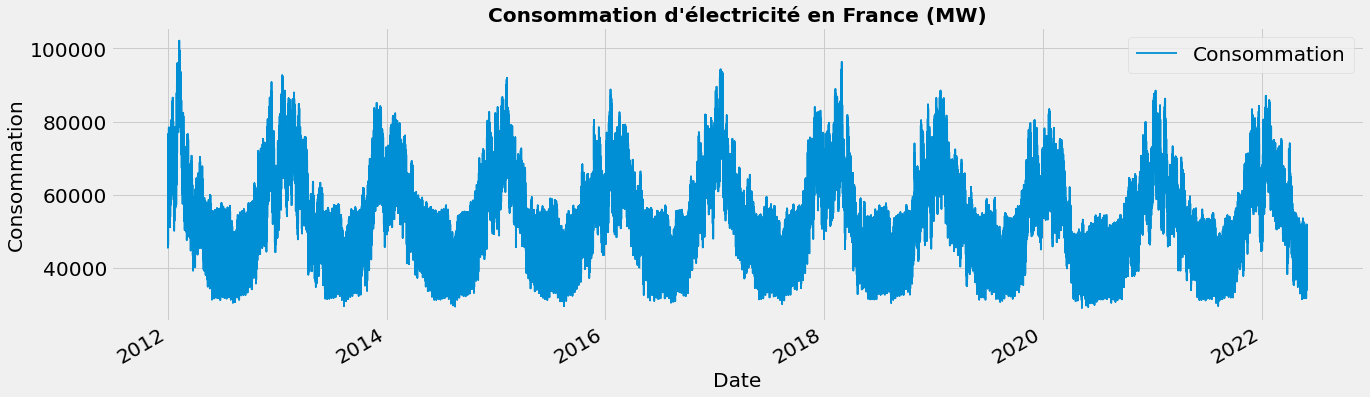

In [17]:
# Visualisation des données :
df.plot()
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.title("Consommation d'électricité en France (MW)")
plt.show()
#plt.savefig("Consommation_elec.pdf")

In [11]:
df.head(10)

,Heure,Consommation
Date,,
2012-01-01,00:00,58315.0
2012-01-01,00:30,58315.0
2012-01-01,01:00,56231.0
2012-01-01,01:30,56075.0
2012-01-01,02:00,55532.0
2012-01-01,02:30,54911.0
2012-01-01,03:00,52496.0
2012-01-01,03:30,50664.0
2012-01-01,04:00,49161.0


In [12]:
df.tail(10)

,Heure,Consommation
Date,,
2022-05-31,19:00,48330.0
2022-05-31,19:30,48107.0
2022-05-31,20:00,47317.0
2022-05-31,20:30,45898.0
2022-05-31,21:00,44677.0
2022-05-31,21:30,44043.0
2022-05-31,22:00,44019.0
2022-05-31,22:30,45067.0
2022-05-31,23:00,46703.0


# 2- Principe du modèle ARIMA:

## Qu'est ce qu'une série temporelle? 

une série temporelle est une suite finie $(x_1, ..., x_n)$ de données indexée par le temps, l'indice de temps peut être le jour, l'année etc, le nombre $n$ est appelé la longueur de la série.

Une série temporelle peur être décomposée en 3 composantes:

1. Tendance : 
elle montre une direction générale des données de la série chronologique sur une longue période. Une tendance peut être croissante , décroissante ou horizontale (stationnaire).

2. Saisonnalité : 
la composante saisonnière présente une tendance qui se répète en ce qui concerne le moment, la direction et l’ampleur, le chocolat par exemple est un produit saisonnier connaîssant de fortes ventes durant Pâcques , Noël et une réduction de ventes durant l'été.

3. Bruit :
qui représente des pics et des creux à intervalles aléatoires.

### Qu'est ce qu'une série stationnaire?

Une série est stationnaire si :

1. La moyenne et la variance de la série ne varient pas dans le temps .

2. La covariance du i-ème terme et du (i+m) -ième terme n'est fonction du temps.



### Pourquoi avoir choisi le modèle ARIMA??

ARIMA est un modèle statistique conçu pour l'analyse et la prédiction des données d'une série temporelle , il permet de déterminer les valeurs intégrées à cette dernière en fonction des précédentes observations , c'est pour cette raison que nous avons choisi ce modèle pour notre projet.


### Paramètres du modèle :

Le modèle ARIMA possède 3 paramètres :p, d et q , il s'écrit de la manière suivante : ARIMA(p, d , q) où:

p : le nombre de décalage qu'il faudra considérer pour le modèle autoregressif .

d : le nombre de fois qu'il faut différentier la série afin de la rendre stationnaire (vous verrez ci-dessus que d=0 car notre processus est déjà stationnaire).

q : l'ordre du modèle MA.


## 2.1 - Aggrégation des données :

In [65]:
len(df)

182592

Nous allons Aggréger les données en prenant la moyenne de la consommation d'électricité par jour.

In [8]:
try:
    weekly_cons = df1.groupby(["Consommation", pd.Grouper(key="Date",freq="D")]).size()
    weekly_cons = weekly_cons.unstack(0) 
except:
    print("\n Here seems to be one issue")


 Here seems to be one issue


In [7]:
df1 = df[['Consommation']].resample('D').mean()
df1 = pd.DataFrame(df1)# convertir l'objet ts en dataframe
df1.tail(10)

,Consommation
Date,
2022-05-22,38580.020833
2022-05-23,44451.333333
2022-05-24,44584.104167
2022-05-25,44421.000000
2022-05-26,39162.208333
2022-05-27,40620.354167
2022-05-28,38766.583333
2022-05-29,38017.583333
2022-05-30,44125.458333


In [35]:
len(df1)

3804

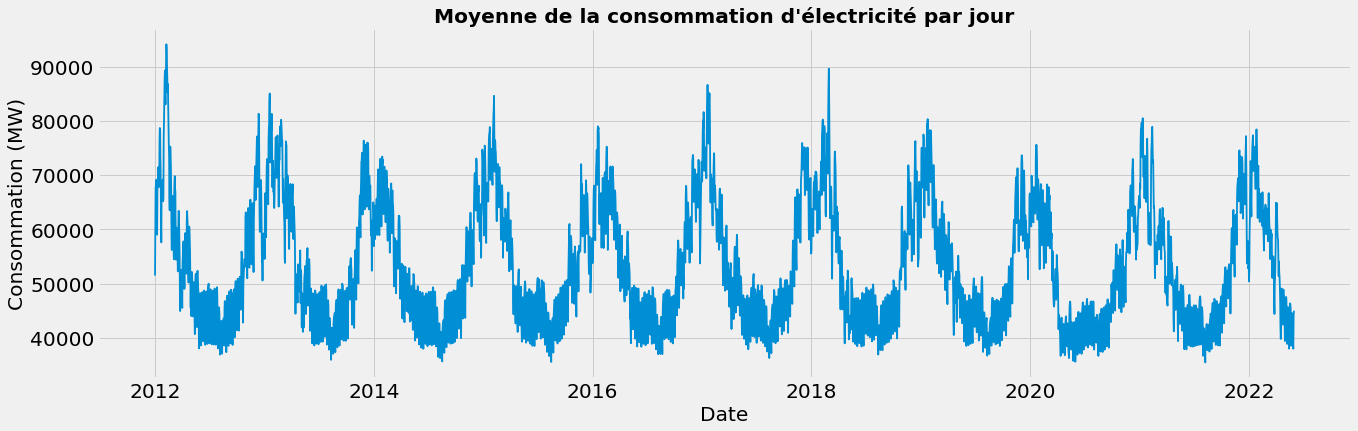

In [11]:
plt.plot(df1)
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.title("Moyenne de la consommation d'électricité par jour")
plt.show()
#plt.savefig("conso_hebdo.pdf")

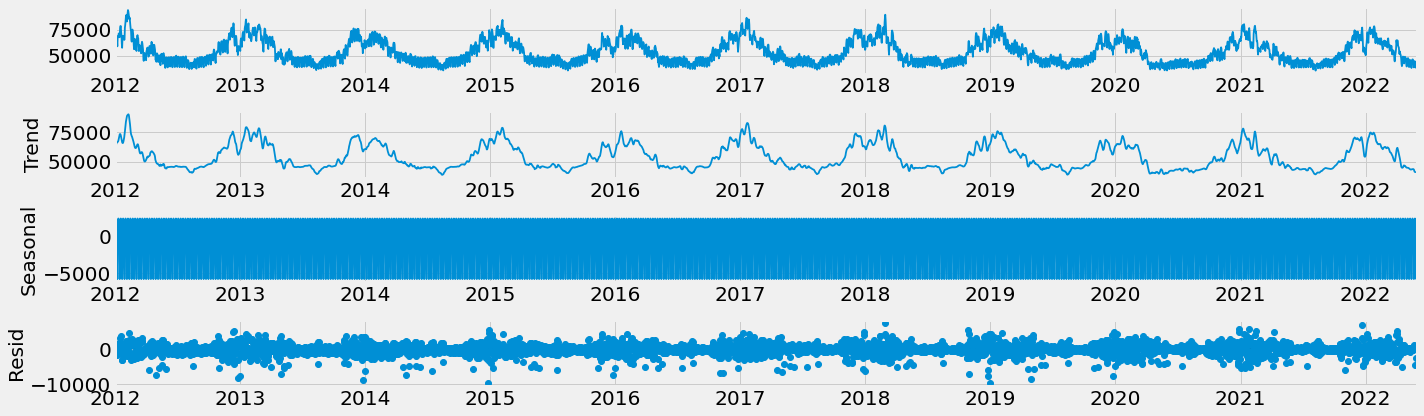

In [38]:
decomp = sm.tsa.seasonal_decompose(df1, model='additive')
fig = decomp.plot()
plt.show()
#plt.savefig("decomp.pdf")

## Test de vérification de la stationnalité de la série temporelle

Afin de tester la stationnalité de la série , nous avons deux méthodes :

1. À l'oeil nu en traçant la moyenne et l'écart type mobile . 

2. En appliquant le test de Dickey-Fuller (nous verrons que c'est une méthode qui prends du temps..)

Si la valeur du paramètre p est inférieure ou égale à 0.05 alors d=0 et notre série est stationnaire (nous rejetons l'hypothèse nulle sinon elle ne l'est pas . 


À partir du package statsmodels, la fonction de test dickey-fuller augmentée est importée. Il renvoie un tuple composé des valeurs : adf, pvalue, usedlag, nobs, critical values etc

Nous allons commencer par définir une fonction qui nous permet d'effectuer tous ces tests :

In [22]:
def get_stationarity(timeseries):
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Données originales')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='green', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    res = adfuller(timeseries['Consommation'])
    print('Statistiques ADF : {}'.format(res[0]))
    print('p-value : {}'.format(res[1]))
    print('Valeurs Critiques :')
    for key, value in res[4].items():
        print('\t{}: {}'.format(key, value))

In [23]:
#Déf d'une fonction qui teste la valeur de p:
def test_val_p(data):
    fuller_test = adfuller(data)
    print('La valeur de p est:' ,fuller_test[1])
    if fuller_test[1] <= 0.05:
        print("la série est stationaire")
    else:
        print("la série n'est pas stationaire")     

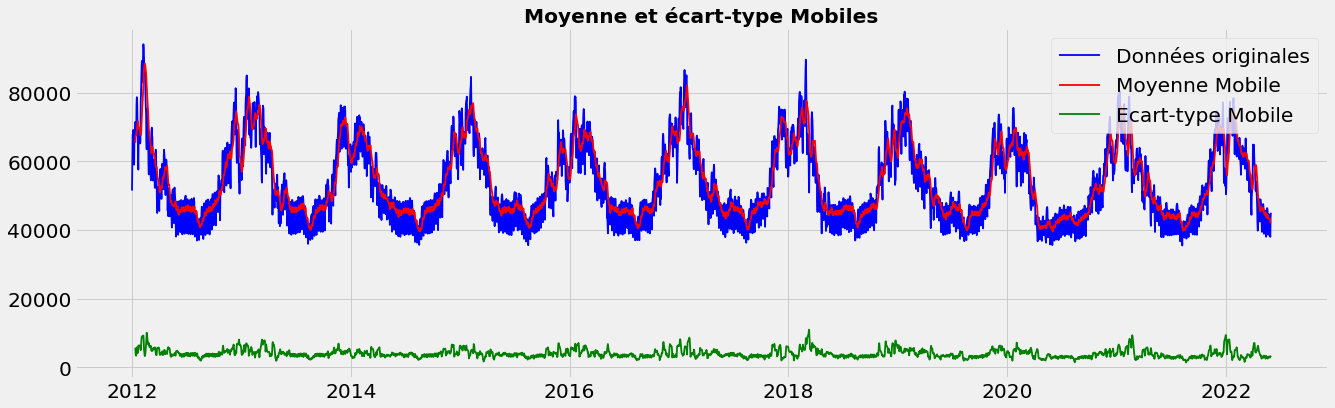

Statistiques ADF : -4.5054944847879606
p-value : 0.00019219323115077355
Valeurs Critiques :
	1%: -3.432084363784655
	5%: -2.8623063464077974
	10%: -2.5671779365227665


<Figure size 1440x432 with 0 Axes>

In [24]:
get_stationarity(df1)
plt.savefig("moy_ecart_type.pdf")

In [39]:
test_val_p(df1) 

La valeur de p est: 0.00019219323115077355
la série est stationaire


 ## Construction du modèle ARIMA:

### Comment obtenir les valeurs de p, d ,q : nous allons utiliser la fonction auto_arima

In [79]:
pip install pmdarima 

Note: you may need to restart the kernel to use updated packages.


In [26]:
#Nous voulons connaître le nombre de combinaisons possibles entre p, d et q:
p=range(0,8)
d=range(0,8)
q=range(0,2)

pdq_comb = list(itertools.product(p,d,q)) 
len(pdq_comb)

128

In [26]:
# Création et test du modèle:
train = df1.loc[df1.index < '2020-12-08']
test = df1.loc[df1.index >= '2020-12-08']


In [27]:
len(df1)

3804

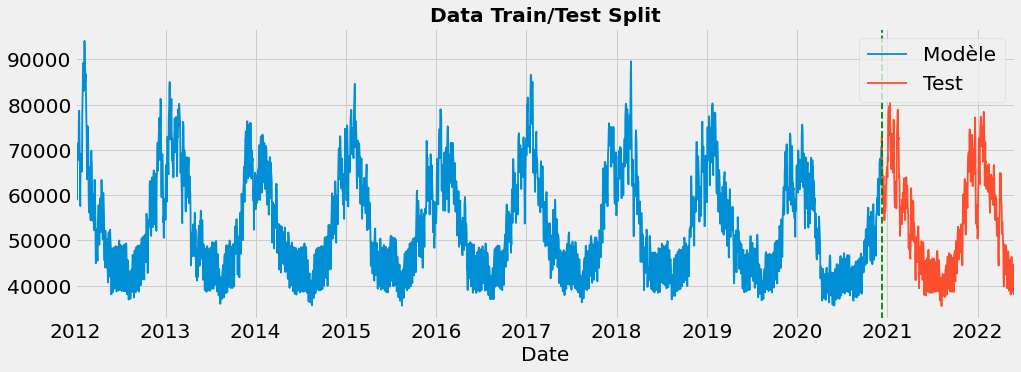

<Figure size 1440x432 with 0 Axes>

In [28]:
# Visualisation train/test split :
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2020-12-08', color='green', ls='--')
ax.legend(['Modèle', 'Test'])
plt.show()
plt.savefig("data_train_tes.pdf")

In [42]:
import pmdarima 

from pmdarima import auto_arima
auto_arima(train, m=12, start_P=0, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=16.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=63211.954, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=62779.606, Time=1.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=62593.917, Time=1.64 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=63209.962, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=63071.921, Time=0.52 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=62573.518, Time=2.87 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=62753.879, Time=1.29 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=62574.004, Time=10.20 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=7.33 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=62571.608, Time=4.04 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=62607.608, Time=2.71 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=62483.240, Time=8.20 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=62441.878, Time=6.46 sec
 ARIMA(1,1,1)(0

ARIMA(order=(5, 1, 3), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

# 3- Application du modèle ARIMA au données:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


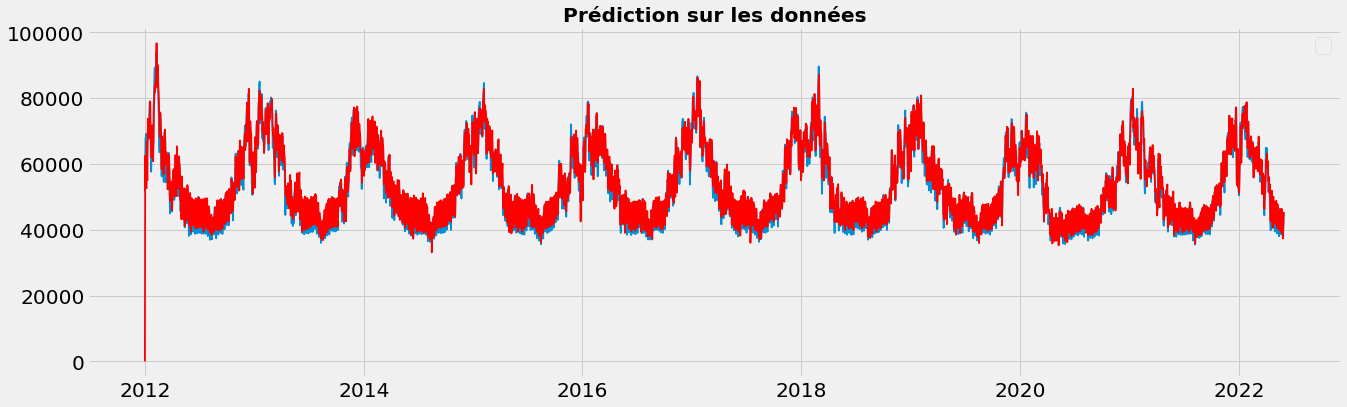

In [12]:
decomposition = seasonal_decompose(df1) 
model = ARIMA(df1, order=(5,1,3), seasonal_order=(0, 0, 2, 12))
results = model.fit()
plt.plot(df1)
plt.plot(results.fittedvalues, color='red')
plt.title('Prédiction sur les données')
plt.legend()

## Application du modèle au test:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


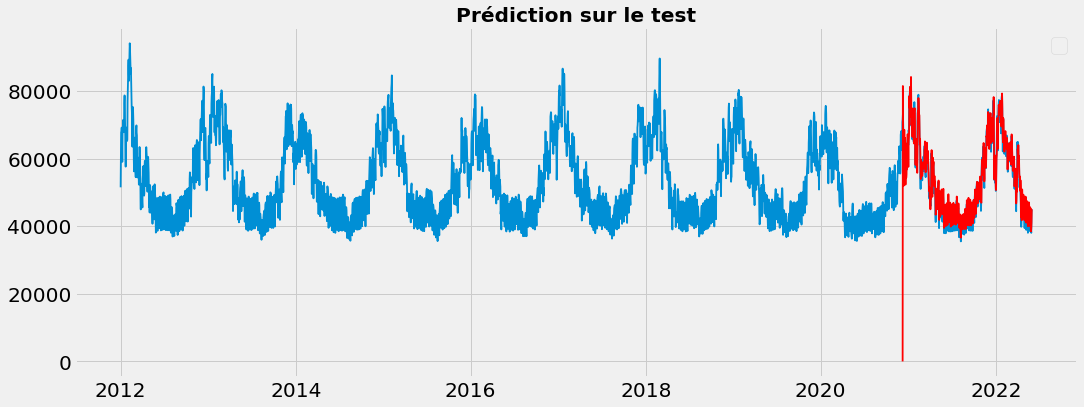

In [49]:
decomposition = seasonal_decompose(df1) 
model = ARIMA(test, order=(5,1,3), seasonal_order=(0, 0, 2, 12))
results = model.fit()
plt.plot(df1)
plt.plot(results.fittedvalues, color='red')
plt.title('Prédiction sur le test')
plt.legend()

In [19]:
df1.tail(10)

,Consommation
Date,
2022-05-22,38580.020833
2022-05-23,44451.333333
2022-05-24,44584.104167
2022-05-25,44421.000000
2022-05-26,39162.208333
2022-05-27,40620.354167
2022-05-28,38766.583333
2022-05-29,38017.583333
2022-05-30,44125.458333


In [17]:
# prédiction du 2022-06-01 jusqu'au 2022-12-08 : 192 jours
from pandas.tseries.offsets import DateOffset
new_dates=[df1.index[-1]+DateOffset(days=x) for x in range(1,192)]
df1_pred=pd.DataFrame(index=new_dates,columns =df1.columns)
df1_pred

,Consommation
2022-06-01,NaN
2022-06-02,NaN
2022-06-03,NaN
2022-06-04,NaN
2022-06-05,NaN
...,...
2022-12-04,NaN
2022-12-05,NaN
2022-12-06,NaN
2022-12-07,NaN


In [57]:
len(df1) 

3804

Le modèle ARIMA prend comme arguments le début et la fin de l'index énuméré et non la plage de dates.

Nous avons créé un datframe vide ayant des index de dates futures et nous allons les concaténer avec notre dataframe d'origine.

Notre dataframe avait 3804 lignes et le nouveau possède 199 lignes, on a au total 4004 lignes.

Par conséquent, pour obtenir les prédictions uniquement pour les données futures, nous allons prédire de la ligne 3805 à 4004 .

,Consommation,predictions
2012-01-01,51491.5,NaN
2012-01-02,60683.645833,NaN
2012-01-03,67762.104167,NaN
2012-01-04,68029.229167,NaN
2012-01-05,69157.395833,NaN


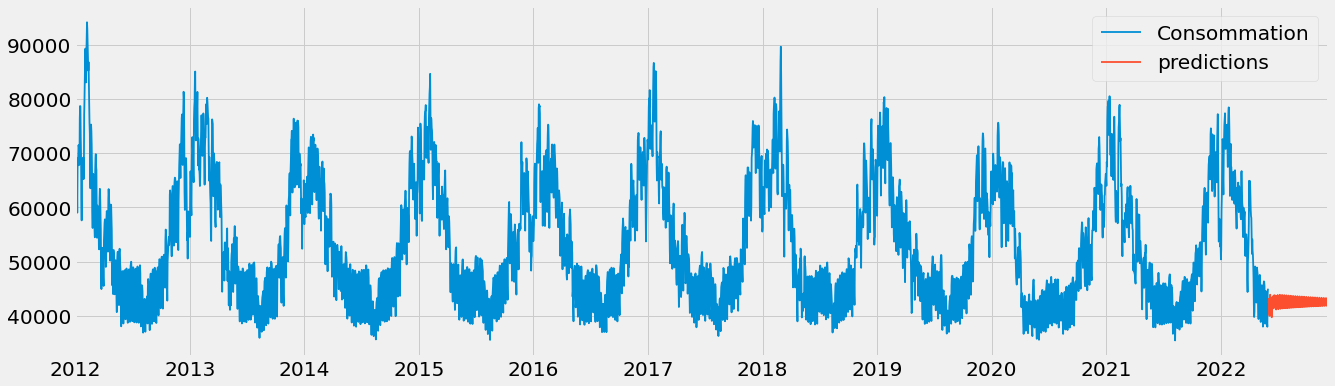

In [29]:
df2=pd.concat([df1,df1_pred])

df2['predictions']=results.predict(start=3805,end=4004)
df2[['Consommation','predictions']].plot()
df2.head()

In [23]:
len(df1_pred)

191

In [24]:
results.resid

Date
2012-01-01    51491.500000
2012-01-02    -1784.022646
2012-01-03    11428.456909
2012-01-04    15366.215242
2012-01-05    14041.377164
                  ...     
2022-05-27     1468.815022
2022-05-28     1411.628090
2022-05-29    -2555.239161
2022-05-30     1977.326558
2022-05-31     -374.128092
Freq: D, Length: 3804, dtype: float64

Text(0.5, 1.0, 'Résidus de la prédiction')

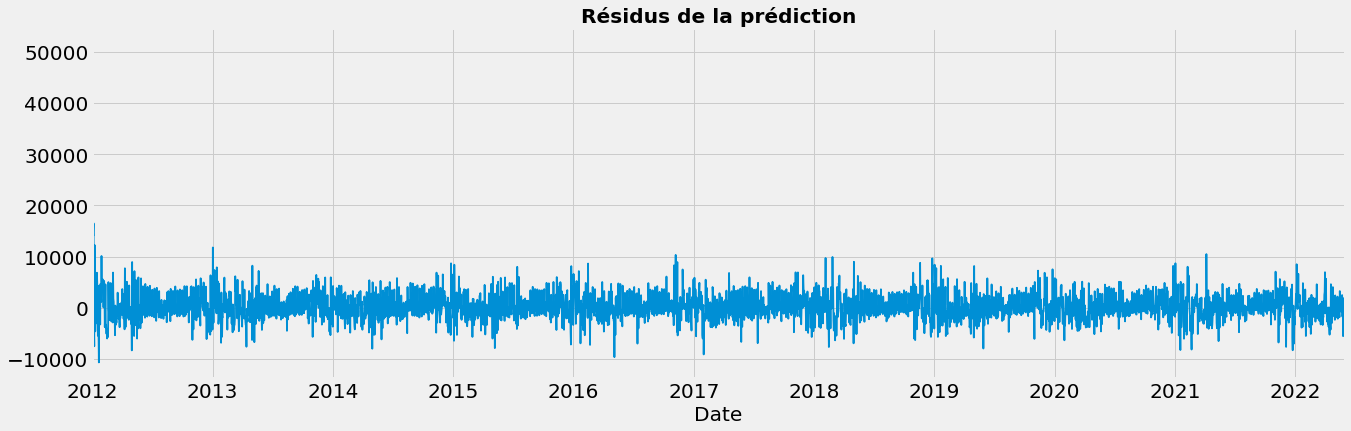

In [31]:
results.resid.plot()
plt.title("Résidus de la prédiction")

<AxesSubplot:ylabel='Density'>

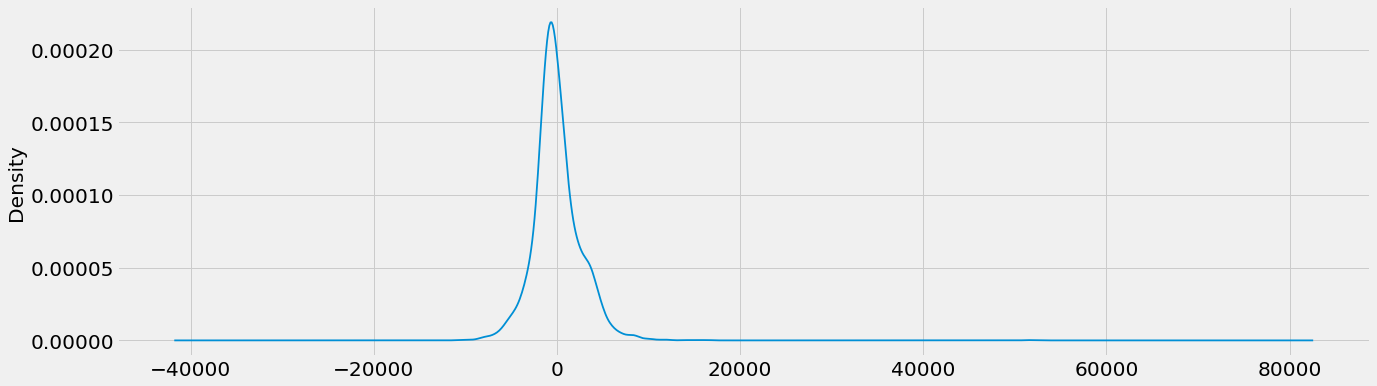

In [26]:
results.resid.plot(kind='kde')

Cette méthode n'a pas vraiment abouti à grand chose , après plusieurs recherches , nous avons trouvé un outil très puissant nommé "prophet" à partir duquel nous allons nous appuyer dans la suite de notre raisonnement.

## Autre méthode : utiliser le package prophet

Prophet est un package qui permet d'effectuer des prévisions des données de séries temporelles basées sur un modèle additif.

Nous allons à présent travailler avec [les données de la consommation d'électricité en France du 01 Juin 2022 jusqu'au 29 novembre 2022](https://odre.opendatasoft.com/explore/dataset/eco2mix-national-tr/download/?format=csv&disjunctive.nature=true&q=date_heure:%5B2022-05-31T22:00:00Z+TO+2022-11-29T22:59:59Z%5D&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B) 

In [2]:
#Téléchargement des données de 2022:
url2="https://odre.opendatasoft.com/explore/dataset/eco2mix-national-tr/download/?format=csv&disjunctive.nature=true&q=date_heure:%5B2022-05-31T22:00:00Z+TO+2022-11-29T22:59:59Z%5D&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B"
path_target = './consommation_2022.csv'
path, fname = os.path.split(path_target)
pooch.retrieve(url2, path=path, fname=fname, known_hash=None)

# Chargement du dataset "consommation.csv"
data1 = pd.read_csv("consommation_2022.csv", delimiter=";", comment="#", na_values="n/d",parse_dates=['Date'], converters={'heure' : str})
data1

,Périmètre,Nature,Date,Heure,Date - Heure,Consommation (MW),Prévision J-1 (MW),Prévision J (MW),Fioul (MW),Charbon (MW),...,Hydraulique - Fil de l'eau + éclusée (MW),Hydraulique - Lacs (MW),Hydraulique - STEP turbinage (MW),Bioénergies - Déchets (MW),Bioénergies - Biomasse (MW),Bioénergies - Biogaz (MW),Stockage batterie (MW),Déstockage batterie (MW),Eolien terrestre (MW),Eolien offshore (MW)
0,France,Données temps réel,2022-07-07,11:00,2022-07-07T11:00:00+02:00,51877,52000,51900,226,33,...,3607,1303,454,185,357,280,ND,ND,ND,ND
1,France,Données temps réel,2022-07-07,13:00,2022-07-07T13:00:00+02:00,53604,54200,54600,191,34,...,3379,1359,555,174,358,280,ND,ND,ND,ND
2,France,Données temps réel,2022-07-07,14:30,2022-07-07T14:30:00+02:00,52239,52600,52300,152,35,...,3050,1028,455,166,358,280,ND,ND,ND,ND
3,France,Données temps réel,2022-07-07,15:45,2022-07-07T15:45:00+02:00,50777,50800,50900,152,38,...,2947,1225,216,181,357,280,ND,ND,ND,ND
4,France,Données temps réel,2022-07-07,16:00,2022-07-07T16:00:00+02:00,50768,50500,50800,152,38,...,2936,1257,214,175,357,280,ND,ND,ND,ND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,France,Données temps réel,2022-08-02,03:15,2022-08-02T03:15:00+02:00,36276,36450,36350,138,24,...,2346,485,17,165,315,275,ND,ND,ND,ND
17468,France,Données temps réel,2022-08-02,03:30,2022-08-02T03:30:00+02:00,35862,36100,36000,138,24,...,2385,493,17,164,316,275,ND,ND,ND,ND
17469,France,Données temps réel,2022-08-02,04:15,2022-08-02T04:15:00+02:00,35226,35500,35400,138,23,...,2380,376,17,171,317,275,ND,ND,ND,ND
17470,France,Données temps réel,2022-08-02,05:45,2022-08-02T05:45:00+02:00,36760,37400,37000,138,23,...,2330,493,19,168,317,275,ND,ND,ND,ND


Afin d'appliquer prophet , notre adataframe doit avoir une forme spécifique :

la première colonne doit porter le nom 'ds' et contenir les dates et la deuxième colonne doit porter le nom de 'y' et contenir ce que l'on veut prédire , dans notre cas 'consommation'.

In [3]:
#Restriction des données sur les modalités "date " ," heure" et "consommation" 
df2 = data1.copy()
df2 = data1[['Date', 'Heure', 'Consommation (MW)']]                   
df2 = df2.rename(columns={'Date' : 'ds', 'Consommation (MW)' : 'y'})
df2 = df2.dropna() #supprimer les valeurs aberrantes 
df2 = df2.sort_values(by=['ds','Heure'], ascending=(True,True)) #ordonner les colonnes 'ds' et 'Heure' dans l'ordre croissant
df2['ds'] = pd.to_datetime(df2['ds']) #convertir l'objet 'ds' en datetime 

In [9]:
df2.head(10)

,ds,Heure,y
8466,2022-06-01,00:00,44940
5236,2022-06-01,00:15,43967
5237,2022-06-01,00:30,42514
1262,2022-06-01,00:45,41073
14061,2022-06-01,01:00,40359
10600,2022-06-01,01:15,40476
14062,2022-06-01,01:30,40049
14063,2022-06-01,01:45,39832
5238,2022-06-01,02:00,39328
8467,2022-06-01,02:15,39778


In [10]:
df2.tail(10)

,ds,Heure,y
15929,2022-11-29,21:30,58456
13858,2022-11-29,21:45,57908
3492,2022-11-29,22:00,57464
3493,2022-11-29,22:15,57087
5039,2022-11-29,22:30,57581
5040,2022-11-29,22:45,59236
13859,2022-11-29,23:00,58590
5041,2022-11-29,23:15,58310
13860,2022-11-29,23:30,57826
13861,2022-11-29,23:45,57893


In [4]:
# Test du modèle :
model = Prophet()
model.fit(df2)
future = model.make_future_dataframe(periods=10 , freq='15min', include_history=False)
forecast = model.predict(future) 

14:32:41 - cmdstanpy - INFO - Chain [1] start processing
14:32:48 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-11-29 00:15:00,56408.729949,52456.790416,64898.320097,56408.729949,56408.729949,1903.428453,1903.428453,1903.428453,1903.428453,1903.428453,1903.428453,0.0,0.0,0.0,58312.158402
1,2022-11-29 00:30:00,56413.433382,52143.930597,64244.264597,56413.433382,56413.433382,1898.982466,1898.982466,1898.982466,1898.982466,1898.982466,1898.982466,0.0,0.0,0.0,58312.415848
2,2022-11-29 00:45:00,56418.136816,52349.344930,64339.314445,56418.136816,56418.136816,1894.587494,1894.587494,1894.587494,1894.587494,1894.587494,1894.587494,0.0,0.0,0.0,58312.724310
3,2022-11-29 01:00:00,56422.840249,51954.376196,64425.702206,56422.840249,56422.840249,1890.253453,1890.253453,1890.253453,1890.253453,1890.253453,1890.253453,0.0,0.0,0.0,58313.093702
4,2022-11-29 01:15:00,56427.543682,52349.551418,64550.198415,56427.543682,56427.543682,1885.989984,1885.989984,1885.989984,1885.989984,1885.989984,1885.989984,0.0,0.0,0.0,58313.533666
5,2022-11-29 01:30:00,56432.247115,52437.503837,64395.817086,56432.247115,56432.247115,1881.806453,1881.806453,1881.806453,1881.806453,1881.806453,1881.806453,0.0,0.0,0.0,58314.053569
6,2022-11-29 01:45:00,56436.950549,51876.666375,64577.009040,56436.950549,56436.950549,1877.711943,1877.711943,1877.711943,1877.711943,1877.711943,1877.711943,0.0,0.0,0.0,58314.662492
7,2022-11-29 02:00:00,56441.653982,52230.258776,64146.347884,56441.653982,56441.653982,1873.715252,1873.715252,1873.715252,1873.715252,1873.715252,1873.715252,0.0,0.0,0.0,58315.369234
8,2022-11-29 02:15:00,56446.357415,52334.510522,64371.430169,56446.357415,56446.357415,1869.824885,1869.824885,1869.824885,1869.824885,1869.824885,1869.824885,0.0,0.0,0.0,58316.182300
9,2022-11-29 02:30:00,56451.060849,51991.804440,64378.861750,56451.060849,56451.060849,1866.049052,1866.049052,1866.049052,1866.049052,1866.049052,1866.049052,0.0,0.0,0.0,58317.109901


In [7]:
forecast[['ds','yhat']]

,ds,yhat
0,2022-11-29 00:15:00,58312.158402
1,2022-11-29 00:30:00,58312.415848
2,2022-11-29 00:45:00,58312.724310
3,2022-11-29 01:00:00,58313.093702
4,2022-11-29 01:15:00,58313.533666
5,2022-11-29 01:30:00,58314.053569
6,2022-11-29 01:45:00,58314.662492
7,2022-11-29 02:00:00,58315.369234
8,2022-11-29 02:15:00,58316.182300
9,2022-11-29 02:30:00,58317.109901


In [8]:
#Prédiction sur 10 jours à partir du 29 novembre :
m = Prophet() 
m.fit(df2) #ajuster notre modèle 'm' sur l'ensemble des données 
f = model.make_future_dataframe(periods=96*10 , freq='15min', include_history=False)
predic = model.predict(f)

14:33:06 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
s = predic[['ds','yhat']] #la colonne 'yhat' contient les prédiction
s

,ds,yhat
0,2022-11-29 00:15:00,58312.158402
1,2022-11-29 00:30:00,58312.415848
2,2022-11-29 00:45:00,58312.724310
3,2022-11-29 01:00:00,58313.093702
4,2022-11-29 01:15:00,58313.533666
...,...,...
955,2022-12-08 23:00:00,62124.852368
956,2022-12-08 23:15:00,62116.282888
957,2022-12-08 23:30:00,62107.275013
958,2022-12-08 23:45:00,62097.818161


In [12]:
predic_finale = s[len(s)-97:959]
predic_finale

,ds,yhat
863,2022-12-08 00:00:00,62319.336327
864,2022-12-08 00:15:00,62315.627898
865,2022-12-08 00:30:00,62311.968864
866,2022-12-08 00:45:00,62308.363708
867,2022-12-08 01:00:00,62304.816753
...,...,...
954,2022-12-08 22:45:00,62132.994155
955,2022-12-08 23:00:00,62124.852368
956,2022-12-08 23:15:00,62116.282888
957,2022-12-08 23:30:00,62107.275013


In [14]:
predic_finale = predic_finale.rename(columns={'ds' : 'Date et Heure', 'yhat' : 'Consommation (MW)'})

In [15]:
predic_finale

,Date et Heure,Consommation (MW)
863,2022-12-08 00:00:00,62319.336327
864,2022-12-08 00:15:00,62315.627898
865,2022-12-08 00:30:00,62311.968864
866,2022-12-08 00:45:00,62308.363708
867,2022-12-08 01:00:00,62304.816753
...,...,...
954,2022-12-08 22:45:00,62132.994155
955,2022-12-08 23:00:00,62124.852368
956,2022-12-08 23:15:00,62116.282888
957,2022-12-08 23:30:00,62107.275013


In [16]:
dataframe = pd.DataFrame(predic_finale)

### Création du dataframe 'prediction.csv'

In [17]:
dataframe.to_csv(path_or_buf='./prediction.csv', sep=';')